In [1]:
#---import libraries relating to data manipulation, visualization---------------------------------------------------
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", None)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json

#-------import libraries to evaluate the deep learning model---------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix, f1_score

import warnings
warnings.filterwarnings('ignore')

#------ import Deep Learning Libraries-------#

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import pickle

import sys
sys.path.append('../../src')  # Add the 'src' directory to the path

#### Import Data Loading and Processing Functions
from multimodal.helper_functions import  reproducible_comp, get_final_df, force_curve_reshape

#### Import Model Architecture
from multimodal.model_architecture import Generic1DCNN
reproducible_comp()

In [2]:
file_path = "../../data/processed_data/force_inner.pkl"
with open(file_path, 'rb') as picklefile:
    data = pickle.load(picklefile)

features_force_inner, category_force_inner, category_names, df_force_inner = get_final_df(data, is_acc_data=0, is_multilabel=1)

labels = category_force_inner.copy()
features = features_force_inner.copy()
feat = force_curve_reshape(features)
print("Features Shape: ", feat.shape)
print("Labels Shape: ", labels.shape)

Features Shape:  (1350, 150)
Labels Shape:  (1350, 4)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(feat, labels, test_size=0.1, 
                                                    random_state=2, shuffle=True, stratify=labels)

In [4]:
X_train, X_, y_train, y_ = train_test_split(X_train, y_train, test_size=0.6, 
                                                    random_state=2, shuffle=True, stratify=y_train)

In [5]:
X_train = X_train.reshape(-1, 1, feat.shape[1])
X_test = X_test.reshape(-1, 1, feat.shape[1])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(486, 1, 150)
(486, 4)
(135, 1, 150)
(135, 4)


# 1DCNN Initialization

In [6]:
# Specify the path where you want to save the JSON file
config_file_path = "../../02_Optuna_Runs/force/best_configs/force_inner_best_configs.json"

# Load the saved configuration
with open(config_file_path, "r") as config_file:
    best_configs = json.load(config_file)

best_params = best_configs["best_params"]

input_channels = 1
num_classes = 4
n_layers = best_params["n_layers"]
kernel_size = best_params["kernel_size"]
stride = best_params["stride"]
padding = best_params["padding"]
hidden_channels = best_params["hidden_channels"]
dropout_prob = best_params["dropout_prob"]
pooling_type = best_params["pooling_type"]
use_batch_norm = best_params["use_batch_norm"]
lr = best_params["lr"]
best_params_json = json.dumps(best_params, indent=4)
print(best_params_json)

{
    "lr": 0.006170767628576648,
    "dropout_prob": 0.03377115813672493,
    "hidden_channels": 73,
    "n_layers": 4,
    "kernel_size": 7,
    "stride": 2,
    "padding": 4,
    "pooling_type": "max",
    "use_batch_norm": true
}


# Training Loop with MultilabelStratifiedKFold Cross validation

In [7]:
from torch.utils.data import DataLoader, TensorDataset

def multi_label_accuracy(y_true, y_pred):
    # Check if each label is correctly predicted
    label_accuracies = np.mean(y_true == y_pred, axis=0)
    # Compute the overall accuracy by taking the mean of label accuracies
    accuracy = np.mean(label_accuracies)
    return accuracy

# Convert your data to PyTorch tensors
x_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Define the number of folds
num_folds = 4  # You can adjust this as needed

# Initialize KFold cross-validation
mskf = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define your loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Lists to store training and validation loss values for each fold
train_losses = []
valid_losses = []

num_epochs = 50

for fold, (train_indices, valid_indices) in enumerate(mskf.split(x_train, y_train)):

    train_losses_fold = []  # Store training losses for this fold
    valid_losses_fold = []  # Store validation losses for this fold

    # Split the data into training and validation sets for this fold
    x_fold_train = x_train[train_indices]
    y_fold_train = y_train[train_indices]
    x_fold_valid = x_train[valid_indices]
    y_fold_valid = y_train[valid_indices]

    train_dataset = TensorDataset(x_fold_train, y_fold_train)
    valid_dataset = TensorDataset(x_fold_valid, y_fold_valid)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

    model = Generic1DCNN(input_channels, num_classes, n_layers, kernel_size, stride,padding,
                      hidden_channels, dropout_prob, pooling_type, use_batch_norm).to(device)
    
    criterion = nn.BCEWithLogitsLoss()

    optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])


    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_losses_fold.append(running_loss / len(train_loader))
        
        # Validation loss calculation (similar to training loop)
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for inputs_valid, labels_valid in valid_loader:
                inputs_valid, labels_valid = inputs_valid.to(device), labels_valid.to(device)
                outputs_valid = model(inputs_valid)
                loss_valid = criterion(outputs_valid, labels_valid.float())
                valid_loss += loss_valid.item()

        valid_losses_fold.append(valid_loss / len(valid_loader))

        if (epoch + 1) % 10 == 0:
            print(f"Fold {fold + 1}, Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / len(train_loader)}, Validation Loss: {valid_loss / len(valid_loader)}")


    train_losses.append(train_losses_fold)
    valid_losses.append(valid_losses_fold)

    # Evaluation on the validation set for this fold
    model.eval()
    y_true_valid = []
    y_pred_valid = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.int()
            outputs = model(inputs)
            predicted = (outputs > 0).int()
            y_true_valid.append(labels.cpu().numpy())
            y_pred_valid.append(predicted.cpu().numpy())

    # Convert lists to NumPy arrays for calculations
    y_true_valid = np.array(y_true_valid[0]).reshape(-1,4)
    y_pred_valid = np.array(y_pred_valid[0]).reshape(-1,4)

    accuracy = multi_label_accuracy(y_true_valid, y_pred_valid)
    print(f"Multi-label Validation Accuracy: {accuracy * 100:.2f}%")



Fold 1, Epoch 10/50, Training Loss: 0.030441621784120798, Validation Loss: 0.029670123010873795
Fold 1, Epoch 20/50, Training Loss: 0.00047013179209898226, Validation Loss: 0.016088413365650922
Fold 1, Epoch 30/50, Training Loss: 9.558866440784186e-05, Validation Loss: 0.015765439020469785
Fold 1, Epoch 40/50, Training Loss: 5.4419079485038914e-05, Validation Loss: 0.015515298524405807
Fold 1, Epoch 50/50, Training Loss: 3.7183166568866e-05, Validation Loss: 0.016425775073003024
Multi-label Validation Accuracy: 98.83%
Fold 2, Epoch 10/50, Training Loss: 0.009990545106120408, Validation Loss: 0.02574621280655265
Fold 2, Epoch 20/50, Training Loss: 0.004411977657582611, Validation Loss: 0.01563778636045754
Fold 2, Epoch 30/50, Training Loss: 0.0012856964434225422, Validation Loss: 0.009181184694170952
Fold 2, Epoch 40/50, Training Loss: 0.00018205475013625497, Validation Loss: 0.007596613315399736
Fold 2, Epoch 50/50, Training Loss: 8.789300485053293e-05, Validation Loss: 0.0055677304044

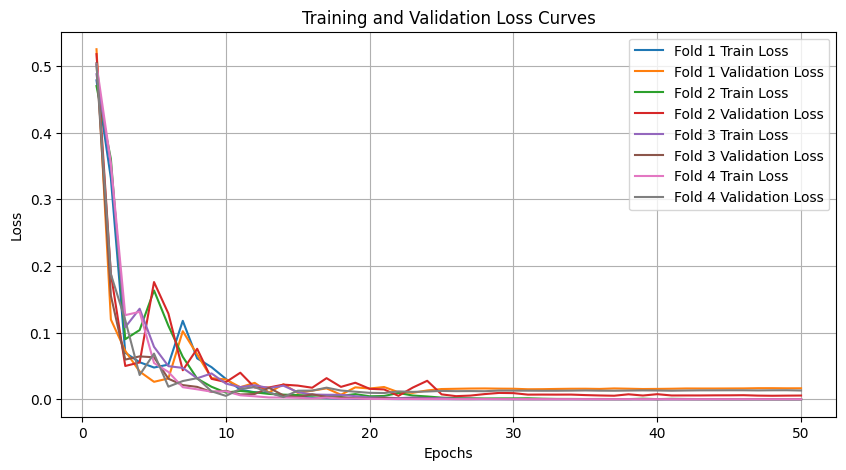

In [8]:
plt.figure(figsize=(10, 5))

# Plot training and validation loss curves for each fold
for fold in range(num_folds):
    plt.plot(range(1, num_epochs + 1), train_losses[fold], label=f'Fold {fold + 1} Train Loss')
    plt.plot(range(1, num_epochs + 1), valid_losses[fold], label=f'Fold {fold + 1} Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
torch.save(model, '../../artifacts/force_inner_supervised_50P.pth')

# Evaluation on Test Data

In [10]:
# Evaluation on test set
model = torch.load('../../artifacts/force_inner_supervised_50P.pth')

Multi-label Accuracy: 100.00%
Multi-label F1-Score: 100.00%
Classification Report:
               precision    recall  f1-score   support

        Dünn       1.00      1.00      1.00        52
    Referenz       1.00      1.00      1.00        27
        Slug       1.00      1.00      1.00        54
        Worn       1.00      1.00      1.00        54

   micro avg       1.00      1.00      1.00       187
   macro avg       1.00      1.00      1.00       187
weighted avg       1.00      1.00      1.00       187
 samples avg       1.00      1.00      1.00       187



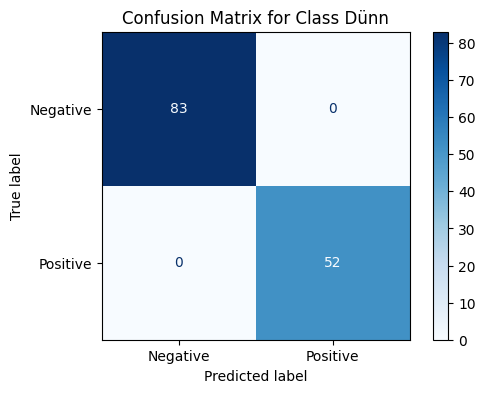

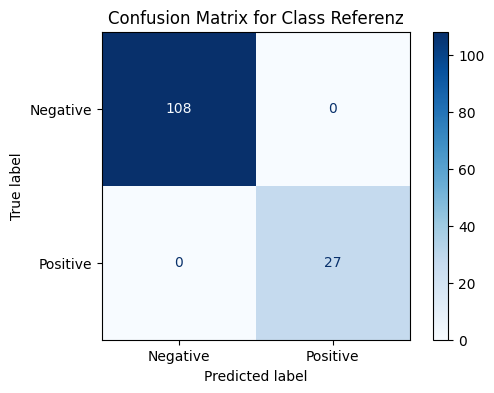

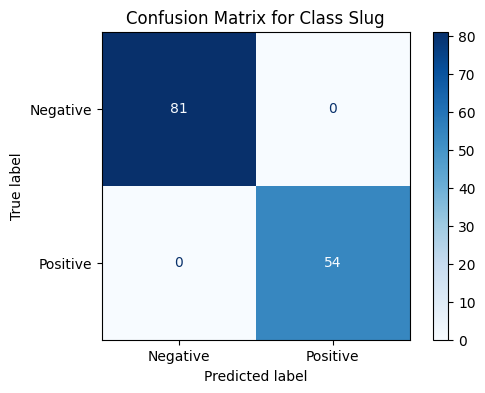

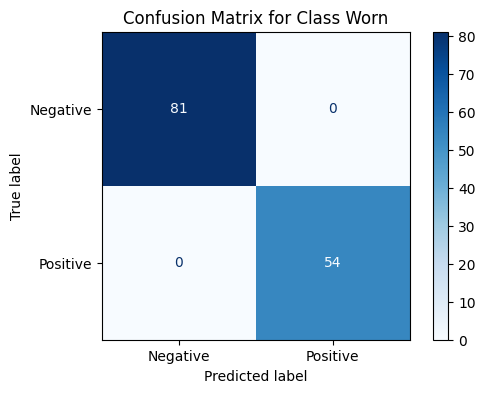

In [11]:
# Evaluation on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in zip(x_test, y_test):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Assuming labels are already binary (0 or 1)
        # Remove the argmax and directly use the labels for true values
        labels = labels.int()
        
        outputs = model(inputs.unsqueeze(0))  # Unsqueeze to add a batch dimension
        predicted = (outputs > 0).int()  # Apply threshold (0.5) to convert to 0 or 1
        
        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())

# Convert lists to NumPy arrays for calculations
y_true = np.array(y_true).reshape(-1,4)
y_pred = np.array(y_pred).reshape(-1,4)

accuracy = multi_label_accuracy(y_true, y_pred)
print(f"Multi-label Accuracy: {accuracy * 100:.2f}%")

f1 = f1_score(y_true, y_pred, average='macro')
print(f"Multi-label F1-Score: {f1 * 100:.2f}%")

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=category_names)
print("Classification Report:\n", report)

# Compute the multi-label confusion matrix
conf_matrix = multilabel_confusion_matrix(y_true, y_pred)


# Visualize each confusion matrix with sample counts
for i, matrix in enumerate(conf_matrix):
    total_samples = matrix.sum()
    
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Negative", "Positive"])
    fig, ax = plt.subplots(figsize=(6, 4))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='.0f')
    ax.set_title(f'Confusion Matrix for Class {category_names[i]}')
    
    plt.show()

In [12]:
print(summary(model,(1, 150)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 73, 76]             584
              ReLU-2               [-1, 73, 76]               0
         MaxPool1d-3               [-1, 73, 38]               0
       BatchNorm1d-4               [-1, 73, 38]             146
            Conv1d-5               [-1, 73, 20]          37,376
              ReLU-6               [-1, 73, 20]               0
         MaxPool1d-7               [-1, 73, 10]               0
       BatchNorm1d-8               [-1, 73, 10]             146
            Conv1d-9                [-1, 73, 6]          37,376
             ReLU-10                [-1, 73, 6]               0
        MaxPool1d-11                [-1, 73, 3]               0
      BatchNorm1d-12                [-1, 73, 3]             146
           Conv1d-13                [-1, 73, 3]          37,376
             ReLU-14                [-1

# Thank You